In [14]:
plt.rcParams['font.size'] = 14

import os
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

import numpy as np
import matplotlib.pyplot as plt

#Load, scale and split Data ################################################################
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

#rescale
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#rescale crude
x = x/400

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)

x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)
##########################################################################

def Show_data(x,L,nSamples = 2,title="data"):
    plt.figure(figsize = (nSamples*3,10))
    for i in range(nSamples):
        plt.plot(np.arange((i+1)*L,(i+1)*L+L),x[i])
        #plt.plot(np.arange(L,2*L),x[1])
        #plt.plot(np.arange(2*L,3*L),x[2])
    plt.title(title)
    plt.xlabel("time")
    plt.show()

def Show_history(fit, EPOCHS):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()


data:  10000


# Weight Initialisation, seed?..

My group as well as others have had issues initialising the weights with the seed. Theoretically if the weights start at one point then the results of training should be the same every time. The weight initalisation is supposed to be the same every time because the seed for the random number generator used is set. 

I know of 3 methods for ensuring consistant initalisation

1. np.random.seed(12345)
   tf_r.set_seed(12345)
   
2. ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05,seed=12345)

3. model.save("myfolder/beforeTraining")
   reconstructed_model = keras.models.load_model("myfolder/beforeTraining")

There are some issues in getting the same result after training with the first two methods.

In [15]:
##method 1
import tensorflow.random as tf_r
def compile_model_seed1(regLevel = 0.2):
    np.random.seed(12345)
    
    tf_r.set_seed(12345)
    ## from keras import regularizers, initializers
    reg = tf.keras.regularizers.l1(regLevel) ## raised to 0.2
    #reg = regularizers.l1(0.1)
    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05,seed=None)
    model = Sequential()
    # -----2-- Convelutional layers
    model.add(Conv1D(filters=2, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class, activation='softmax')) # softmax !
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

INFO:tensorflow:Assets written to: /home/daniel/CompLabB/CompLabB-UNIPD-TeamDream/Daniel/04_XGBoost/assets


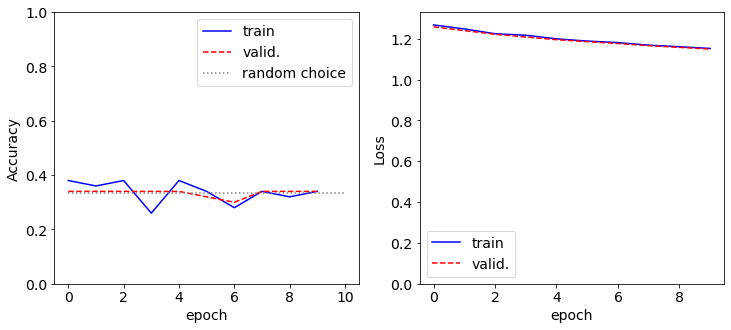

In [20]:
## use small data to decrease stability for more distinguashable features
Ndat = 100
x_train = x_train[0:Ndat,:]
y_train = y_train[0:Ndat]
x_val = x_val[0:Ndat,:]
y_val = y_val[0:Ndat]
EPOCHS = 10
BATCH_SIZE = 10


model_seed1 = compile_model_seed1()

#used to save best weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = os.getcwd(),
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = 0)

fit = model_seed1.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True,callbacks=[model_checkpoint_callback])

Show_history(fit, EPOCHS)

INFO:tensorflow:Assets written to: /home/daniel/CompLabB/CompLabB-UNIPD-TeamDream/Daniel/04_XGBoost/assets


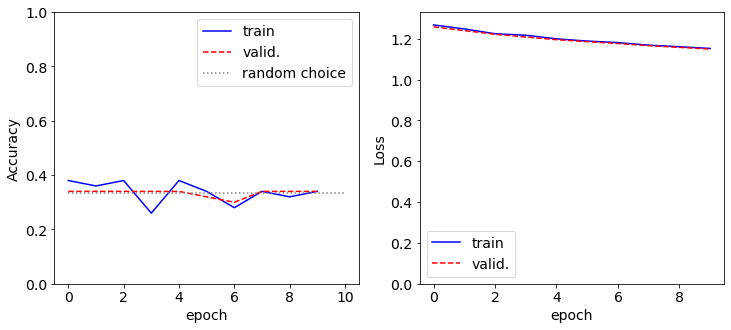

In [21]:
## use small data to decrease stability for more distinguashable features
Ndat = 100
x_train = x_train[0:Ndat,:]
y_train = y_train[0:Ndat]
x_val = x_val[0:Ndat,:]
y_val = y_val[0:Ndat]
EPOCHS = 10
BATCH_SIZE = 10


model_seed2 = compile_model_seed1()

#used to save best weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = os.getcwd(),
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = 0)

fit = model_seed2.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True,callbacks=[model_checkpoint_callback])

Show_history(fit, EPOCHS)

INFO:tensorflow:Assets written to: /home/daniel/CompLabB/CompLabB-UNIPD-TeamDream/Daniel/04_XGBoost/assets


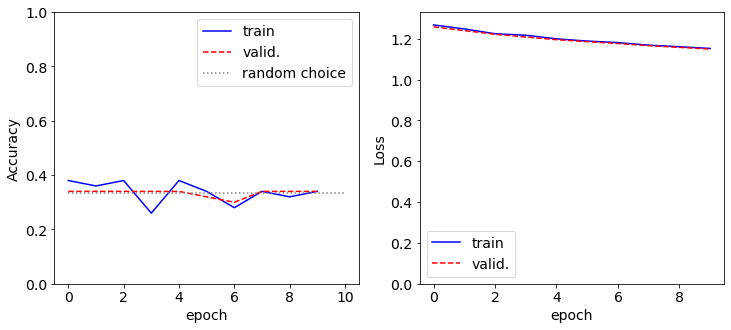

In [22]:
## use small data to decrease stability for more distinguashable features
Ndat = 100
x_train = x_train[0:Ndat,:]
y_train = y_train[0:Ndat]
x_val = x_val[0:Ndat,:]
y_val = y_val[0:Ndat]
EPOCHS = 10
BATCH_SIZE = 10


model_seed2 = compile_model_seed1()

#used to save best weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = os.getcwd(),
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = 0)

fit = model_seed2.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True,callbacks=[model_checkpoint_callback])

Show_history(fit, EPOCHS)

The graphs come up the same every time. So the method one works 